In [11]:
import torch
#  from NN_ANARX.NARX import NARX
from NN_ANARX.ANARX import ANARX
import matplotlib.pyplot as plt
from tqdm import tqdm
from NN_ANARX.utilities import lag_matrix
import scipy.io



In [12]:
# data loading and preparation
data = scipy.io.loadmat("data/1803")
in1 = data["u1_t"]
in2 = data["u2_t"]
out = data["y_t"]

out = torch.Tensor(out).squeeze()
in1 = torch.Tensor(in1).squeeze()
in2 = torch.Tensor(in2).squeeze()
in1_lagged = lag_matrix(in1, 5)
out_lagged = lag_matrix(out, 14)
in2_lagged = lag_matrix(in2, 5)

In [13]:
# create SANARX-Model
model = ANARX(14, [5, 5], n_hidden=3, layersize= 10, SANARX=True)

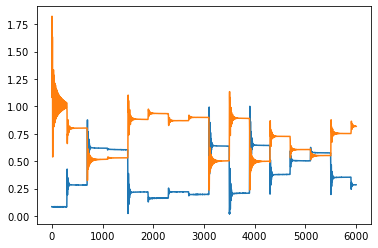

In [4]:
# Compare initial model prediction to real output
plt.plot(out.detach().numpy())
plt.plot(model.justpredict([in1, in2]).detach().numpy())
plt.show()

In [6]:
# Perform 200 Episodes of Open-Loop-Training
optim = torch.optim.Adam(model.parameters())
crit = torch.nn.MSELoss()
dataset = torch.utils.data.TensorDataset(in1_lagged, in2_lagged, out_lagged, out)
loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
for epoch in tqdm(range(100)):
    for i1, i2, ol, os in loader:
        optim.zero_grad()
        result = model(ol, [i1, i2])
        loss = crit(result, os)
        loss.backward()
        optim.step()

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


In [8]:
# Perform 20 Episodes of Closed-Loop-Training
optim = torch.optim.Adam(model.parameters())
crit = torch.nn.MSELoss()
for i in tqdm(range(20)):
    optim.zero_grad()
    pred = model.predict([in1, in2])
    loss = crit(pred, out)
    loss.backward()
    optim.step()

100%|██████████| 2/2 [00:56<00:00, 28.23s/it]


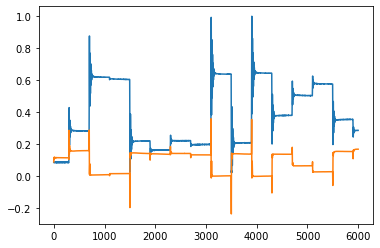

In [9]:
# Compare learned model prediction to real output
plt.plot(out.detach().numpy())
plt.plot(model.justpredict([in1, in2]).detach().numpy())
plt.show()

In [8]:
# save model
torch.save(model, 'models/model.pt')